In [12]:
import numpy as np
import scipy.io as sio
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.contrib.layers import xavier_initializer


import matplotlib.pyplot as plt
%matplotlib inline

data_file = 'data/preprocessed.mat'

EPS = 1e-8
random_seed = 1234

In [13]:
data = sio.loadmat(data_file)

In [14]:
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'images', 'bags', 'labels', 'n_instance', 'instance_dim'])

In [15]:
X = data['bags']
Y = data['labels']
Y[Y != 1] = -1 #convert to 1,-1 labelling

In [16]:
n_instance = data['n_instance']
instance_dim = np.prod(data['instance_dim'])
n_classes = Y.shape[1]

# Train, validate, test split

In [17]:
test_prop = 1/3
validate_prop = 1/6

random_state = 42

X_train, X_test, Y_train, Y_test = train_test_split(
    X, Y,                            
    test_size=test_prop,                             
    random_state=random_state
)

X_train, X_validate, Y_train, Y_validate = train_test_split(
    X_train, Y_train,                   
    test_size=validate_prop/(1-test_prop), 
    random_state=random_state
)

In [18]:
print(Y_train.shape)
print(Y_validate.shape)
print(Y_test.shape)

(999, 5)
(334, 5)
(667, 5)


In [19]:
X_train.shape

(999, 20, 1200)

In [20]:
np.mean(Y == 1)

0.2472

# SVM

Linear model:
$$h_{ijk} = <\vec{x_{ij}}, \vec{w_k}> + b_k$$ 


$$\mathscr{L}(\mathbf{w}_1,\ldots,\mathbf{w}_K) = \frac{1}{2}\sum_{k = 1}^K \mathbf{w}_k^T\mathbf{w}_k + \lambda \sum_{i} \quad \sum_{k} \quad \sum_{k'=1,k' \neq k} max\left(0, \ 1-y_{i \bullet k}\max_j \left(h_{ijk'} - h_{ijk}\right)\right) $$

In [21]:
class MCMIL(object):
    def __init__(self, instance_dim, n_classes):
        self.instance_dim = instance_dim
        self.n_classes = n_classes
        
        #Weights
        xavier_init = xavier_initializer(seed = random_seed)
        W = tf.Variable(xavier_init(
            [
                instance_dim,
                n_classes
            ]
        ), name = 'W')
        self.W = W
        
        b = tf.Variable(np.zeros(
            [
                n_classes
            ]
        ).astype('float32'), name = 'b')
        self.b = b
        
        self.params = [W, b]
        
        #Placeholders
        X = tf.placeholder(tf.float32, shape = [None, None, instance_dim])
        self.X = X
        Y = tf.placeholder(tf.float32, shape = [None, n_classes])
        self.Y = Y
        lamb = tf.placeholder(tf.float32, shape = 1)
        self.lamb = lamb
        
        #Loss
        h_ijk = tf.einsum('ijl,lk->ijk', X, W) + b
        self.h_ijk = h_ijk
        h_kp_minus_k = (h_ijk[:,:,:,tf.newaxis] - h_ijk[:,:,tf.newaxis,:])
        tosum = tf.maximum(0.0, 1 - Y[:,:,tf.newaxis]*tf.reduce_max(h_kp_minus_k, 1))
        mask = 1-tf.diag(tf.ones([tosum.shape[-1]]))
        clf_loss = tf.reduce_sum(mask[tf.newaxis,:,:] * tosum)
        
        L = .5*tf.reduce_mean(tf.einsum('ij,ij->j', W, W)) + lamb * clf_loss
        self.Loss = L
        
    def train(self, x, y, lamb = 1, epochs = 100, mb_size = 50, lr = .01, print_every = 100,):
        #Optimizer 
        solver = tf.train.AdagradOptimizer(learning_rate = lr).minimize(self.Loss, var_list=self.params)
        
        #Training
        init = tf.global_variables_initializer()
        sess = tf.Session()
        self.sess = sess
        with sess.as_default():
            sess.run(init)
            n_batches = int(len(y)/float(mb_size))
            losses = []
            for epoch in range(epochs):
                if epoch % print_every == 0:
                    print(epoch)
                idxs = np.arange(len(y))
                np.random.shuffle(idxs)
                epochloss = 0
                for batch in range(n_batches):
                    mb_idxs = idxs[batch*mb_size:(1+batch)*mb_size]
                    x_mb = x[mb_idxs]
                    y_mb = y[mb_idxs]
                    _, loss = sess.run([solver, self.Loss], feed_dict = {self.X:x_mb, self.Y:y_mb, self.lamb: [lamb]})
                    epochloss += loss/n_batches
                losses.append(epochloss)
            plt.plot(losses)
    
    def predict_instance_proba(self, x):
        return(self.sess.run([tf.sigmoid(self.h_ijk)], feed_dict = {self.X:x}))
    
    def predict_bag_proba(self, x):
        return(self.sess.run([tf.sigmoid(tf.reduce_max(self.h_ijk, 1))], feed_dict = {self.X:x}))

In [22]:
def proba_to_label(p):
    return((p > .5).astype(int)*2 - 1)

In [23]:
mcmil = MCMIL(X.shape[-1], Y.shape[-1])

0


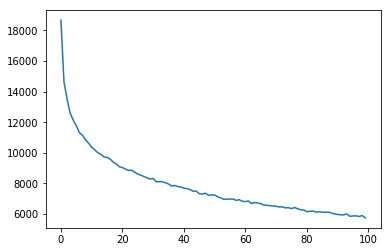

In [24]:
mcmil.train(X_train, Y_train, lamb = .1, epochs = 100, mb_size = 100, lr = .001, print_every = 100)

In [48]:
Yhat = np.array([[1 if k in np.unique(row) else -1 for k in range(Y.shape[-1])] for row in np.argmax(mcmil.predict_instance_proba(X_train)[0], -1)])

In [50]:
np.mean(Yhat == Y_train)

0.37777777777777777

In [29]:
X_train.shape

(999, 20, 1200)

In [202]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

Training accuracy: 0.246


In [203]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

Validation accuracy: 0.256


0
100
200
300
400
500
600
700
800
900


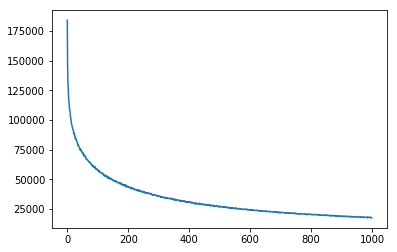

In [204]:
mcmil.train(X_train, Y_train, lamb = 1, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

In [205]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

Training accuracy: 0.246


In [206]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

Validation accuracy: 0.256


In [ ]:
mcmil.train(X_train, Y_train, lamb = 10, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

0
100
200
300
400


In [ ]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

In [ ]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)

In [ ]:
mcmil.train(X_train, Y_train, lamb = 100, epochs = 1000, mb_size = 100, lr = .001, print_every = 100)

In [ ]:
p_train = mcmil.predict_bag_proba(X_train)[0]
Y_hat_train = proba_to_label(p_train)
acc_train = np.mean(Y_hat_train == Y_train)
print("Training accuracy: %.3f" %acc_train)

In [ ]:
p_validate = mcmil.predict_bag_proba(X_validate)[0]
Y_hat_validate = proba_to_label(p_validate)
acc_validate = np.mean(Y_hat_validate == Y_validate)
print("Validation accuracy: %.3f" %acc_validate)